In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("ca87.csv.gz",compression='gzip')
df.authorship.value_counts().head(30)

PER CURIAM    1876
SLOVITER      1638
BUFFINGTON    1336
RENDELL       1150
BECKER        1051
AMBRO         1029
ROTH           974
SCIRICA        961
SMITH          911
GREENBERG      898
NYGAARD        893
STAPLETON      881
ALDISERT       874
WEIS           873
GIBBONS        856
FISHER         856
BIGGS          850
FUENTES        807
GARTH          757
SEITZ          714
ROSENN         709
WOOLLEY        704
McKEE          698
BARRY          678
COWEN          647
CHAGARES       637
McPHERSON      627
JORDAN         626
ADAMS          622
HARDIMAN       579
Name: authorship, dtype: int64

In [3]:
df.authorship = df.authorship.str.upper()
names = []
for i in df.authorship.value_counts().head(100).index:
    if i != 'PER CURIAM':
        names.append(i)
copy = pd.DataFrame()
temp = df[df.word_count > 50]
for name in names:
    copy = copy.append(temp[temp.authorship == name])
copy.date_standard = copy.date_standard.str[:4]
copy.date_standard = copy.date_standard.astype(int)
copy = copy.drop(columns=['opinion_type','opinion_id','word_count','authors','dc_source','judges_refined'])
copy

,dc_identifier,opinion,authorship,date_standard
46,4G4V-YKC0-0038-X09M-00000-00,"SLOVITER, Circuit Judge.\n\nMaria Jaramillo, 1...",SLOVITER,2005
63,4HV6-G5N0-0038-X07F-00000-00,"SLOVITER, Circuit Judge.\n\n515 Associates, LL...",SLOVITER,2005
71,4HW2-BX30-0038-X0HP-00000-00,"SLOVITER, Circuit Judge\n\nOn October 31, 2002...",SLOVITER,2005
78,454N-7MS0-0038-X433-00000-00,"OPINION OF THE COURT\n\nSLOVITER, Circuit Judg...",SLOVITER,2002
90,57H2-KW31-F04K-K31P-00000-00,"SLOVITER, Circuit Judge.\n\nPatricia Catullo a...",SLOVITER,2013
...,...,...,...,...
43115,7X7M-64K0-YB0V-F037-00000-00,"OPINION OF THE COURT\n\nHARDIMAN, Circuit Judg...",HARDIMAN,2009
43178,58NW-DKV1-F04K-K002-00000-00,"OPINION OF THE COURT\n\nHARDIMAN, Circuit Judg...",HARDIMAN,2013
49265,5KC6-5461-F04K-K1TX-00000-00,"HARDIMAN, Circuit Judge, with whom AMBRO, FUEN...",HARDIMAN,2016
51929,5918-4N01-F04K-K026-00000-00,"HARDIMAN, Circuit Judge, dissenting.\n\nThe Se...",HARDIMAN,2013


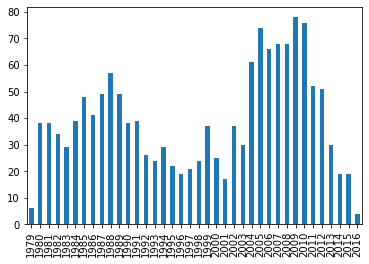

In [4]:
copy[copy.authorship == names[0]].date_standard.value_counts().sort_index().plot(kind='bar')

In [5]:
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge','')
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Senior District Judge','')
copy.opinion = copy.opinion.str.replace('Senior District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judges','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGES','')
copy.opinion = copy.opinion.str.replace('District Judges','')
copy.opinion = copy.opinion.str.replace('District Judges'.upper(),'')
copy.opinion = copy.opinion.str.replace('District Judge','')
copy.opinion = copy.opinion.str.replace('District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judge','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGE','')
copy.opinion = copy.opinion.str.replace('Circuit Justice','')
copy.opinion = copy.opinion.str.replace('Circuit Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('D\.J\.','')
copy.opinion = copy.opinion.str.replace('D\. J\.','')
copy.opinion = copy.opinion.str.replace('C\.J\.','')
copy.opinion = copy.opinion.str.replace('C\. J\.','')
copy.opinion = copy.opinion.str.replace('Senior Judge','')
copy.opinion = copy.opinion.str.replace('Senior Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Associate Justice','')
copy.opinion = copy.opinion.str.replace('Associate Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('Chief Judge','')
copy.opinion = copy.opinion.str.replace('Chief Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Judge','')
copy.opinion = copy.opinion.str.replace('Judge'.upper(),'')

for name in names:
    copy.opinion = copy.opinion.str.replace(name.upper(),'')
    copy.opinion = copy.opinion.str.replace(name,'')
    copy.opinion = copy.opinion.str.replace(name[:1].upper()+name[1:].lower(),'')

copy.opinion = copy.opinion.str.replace('McKEE',' ')
copy.opinion = copy.opinion.str.replace('McKee',' ')
copy.opinion = copy.opinion.str.replace('McPherson',' ')
copy.opinion = copy.opinion.str.replace('McPHERSON',' ')
copy.opinion = copy.opinion.str.replace('J\.',' ')
copy.opinion = copy.opinion.str.replace('\n',' ')

In [6]:
copy.opinion = copy.opinion.str.replace('\\\'','')
copy.opinion = copy.opinion.str.replace('(','')
copy.opinion = copy.opinion.str.replace(')','')
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\w\.", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\,", ",", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\d+", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"-", "", x))
copy.opinion = copy.opinion.str.replace('S\.C\.','')
copy.opinion = copy.opinion.str.replace('Ct\.','Ct')
copy.opinion = copy.opinion.str.replace('Ed\.','Ed')
copy.opinion = copy.opinion.str.replace('Dec\.','Dec')
copy.opinion = copy.opinion.str.replace(' No\.',' No')
copy.opinion = copy.opinion.str.replace(' pt\.',' pt')
copy.opinion = copy.opinion.str.replace(' Rep\.',' Rep')
copy.opinion = copy.opinion.str.replace(' Tr\.',' Tr')
copy.opinion = copy.opinion.str.replace(' Arg\.',' Arg')
copy.opinion = copy.opinion.str.replace(' Nev\.',' Nev')
copy.opinion = copy.opinion.str.replace(' Rev\.',' Rev')
copy.opinion = copy.opinion.str.replace(' Stat\.',' Stat')
copy.opinion = copy.opinion.str.replace(' Cent\.',' Cent')
copy.opinion = copy.opinion.str.replace(' Ore\.',' Ore')
copy.opinion = copy.opinion.str.replace(' Co\.',' Co')
copy.opinion = copy.opinion.str.replace(' Ins\.',' Ins')
copy.opinion = copy.opinion.str.replace('S\.','')
copy.opinion = copy.opinion.str.replace('Cf\.','Cf')
copy.opinion = copy.opinion.str.replace('Id\.','Id')
copy.opinion = copy.opinion.str.replace(' ,',',')
copy.opinion = copy.opinion.str.replace(' \.','.')
copy.opinion = copy.opinion.str.replace('§','')
copy.opinion = copy.opinion.str.replace('$','')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',\.',',')
copy.opinion = copy.opinion.str.replace('"',' ')
copy.opinion = copy.opinion.str.replace('II','')
copy.opinion = copy.opinion.str.replace('III','')
copy.opinion = copy.opinion.str.replace('  ',' ')

In [7]:
# Prints the first 200 characters of the first 10 cleaned opinion texts of a given judge.
judge = 0
print(names[judge]+'\n')
for x in range(10):
    print(copy.opinion[copy.loc[copy.authorship==names[judge]].index[x]][:200]+'\n\n')

SLOVITER

, Maria Jaramillo, Although the dockets in the Social Security Administration, District Court and this court spell appellants name as Jaramilla, the underlying record shows her name as Jaramillo and w


,  Associates, LLC  Associates appeals from the order of the District Court granting summary judgment in favor of defendant Travelers Indemnity Company Travelers . The District Court had jurisdiction 


,  On October, Marisela Vallejo DeMurillo, pursuant to a plea agreement, entered a plea of guilty to a two count information charging her with conspiring to distribute and possess with the intent to d


OPINION OF THE COURT, The petitioner, Sultan Chemists, Inc. Sultan , has filed a petition for review of the final decision of the Environmental Appeals Board EAB of the Environmental Protection Agency


, Patricia Catullo appeals the District Courts grant of summary judgment in favor of her former employer, Liberty Mutual Group, Inc. and Liberty Mutual Insurance Company, Inc. co

In [8]:
#get rough estimate for total number of top 10 authors in all 3 splits
top = 2000
bot = 1970
split1 = pd.DataFrame()
for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split1 = split1.append(temp[temp.date_standard<=bot])
split2 = pd.DataFrame()
for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
split3 = pd.DataFrame()
for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split3 = split3.append(temp[temp.date_standard>=top])

for i in range(3):
    totalNum = split1.shape[0]+split2.shape[0]+split3.shape[0]
    print('totalNum = '+str(totalNum))
    print(split1.shape)
    print(split2.shape)
    print(split3.shape)    

    #initialize the splits so we can iterate over them
    top = 2020
    bot = 1800
    split1 = pd.DataFrame()
    for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split1 = split1.append(temp[temp.date_standard<=bot])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    split3 = pd.DataFrame()
    for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split3 = split3.append(temp[temp.date_standard>=top])
    
    
    
    
    #loop to iterate 
    while split1.shape[0] < totalNum/3:
        bot += 1
        split1 = pd.DataFrame()
        for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split1 = split1.append(temp[temp.date_standard<=bot])    
    while split3.shape[0] < totalNum/3:
        top -= 1
        split3 = pd.DataFrame()
        for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split3 = split3.append(temp[temp.date_standard>=top])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    

    print(split1.shape)
    print(split2.shape)
    print(split3.shape)
    print('top = '+str(top)+' bot = '+str(bot))

totalNum = 17820
(3699, 4)
(5817, 4)
(8304, 4)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(5957, 4)
(5248, 4)
(6200, 4)
top = 2007 bot = 1983
totalNum = 17405
(5957, 4)
(5248, 4)
(6200, 4)
(5802, 4)
(5362, 4)
(6200, 4)
top = 2007 bot = 1982
totalNum = 17364
(5802, 4)
(5362, 4)
(6200, 4)
(5802, 4)
(5362, 4)
(6200, 4)
top = 2007 bot = 1982


# Bag of Words approach

## Split 1

In [9]:
split1.authorship.value_counts()

BUFFINGTON    1329
BIGGS          843
WOOLLEY        703
MCPHERSON      628
GIBBONS        513
ADAMS          454
SEITZ          382
ALDISERT       372
ROSENN         330
GARTH          248
Name: authorship, dtype: int64

In [10]:
print('Number of Datapoints: ', split1.shape[0])

Number of Datapoints:  5802


In [11]:
split1names = split1.authorship.unique()

for index, name in enumerate(split1names):
    split1.authorship = split1.authorship.str.replace(name, str(index))
split1.authorship = split1.authorship.astype(int)

In [12]:
vectorizer1 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM1 = vectorizer1.fit_transform(split1.opinion)
#print(bowM1.toarray().shape)
#print(vectorizer1.get_feature_names())

In [13]:
X1 = pd.DataFrame.sparse.from_spmatrix(bowM1)
X1 = X1.sparse.to_dense()

In [14]:
for x in range(0,len(X1.columns)):
    mean = X1.iloc[:,x].mean()
    std = X1.iloc[:,x].std()
    X1.iloc[:,x] = (X1.iloc[:,x] - mean)/std

In [15]:
Y1 = split1.authorship.to_frame().reset_index().drop(columns=['index'])

X1_Training, X1_Testing, y1_Training, y1_Testing = train_test_split(X1, Y1, test_size=0.2, random_state=1234)

In [16]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_Training, y1_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X1_train), np.array(y1_train))
    values = classifier.predict_proba(np.array(X1_test))
    
    correct = 0
    counter = 0
    for k in range(0,y1_test.size):
        if np.amax(values[k]) == values[k][int(y1_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.83745963401507


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.852529601722282


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8493003229278795


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8568353067814855


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8557588805166846
Accuracy:  0.8503767491926804  +/-  0.006976039503130091


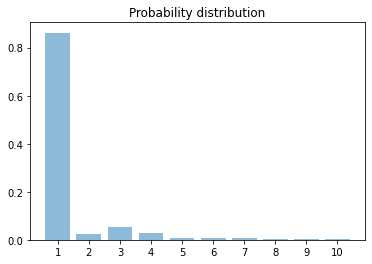

Accuracy:  0.8466838931955211


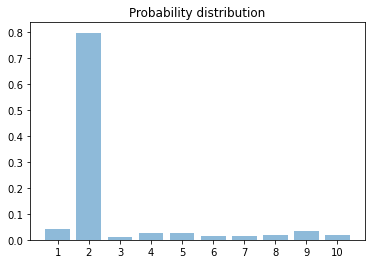

Accuracy:  0.8466838931955211


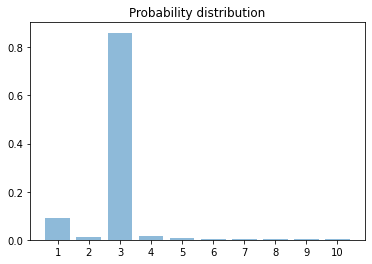

Accuracy:  0.8466838931955211


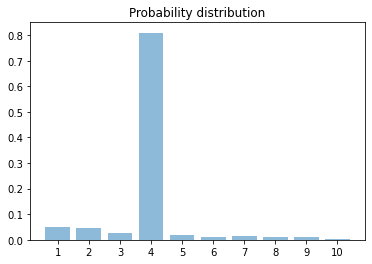

Accuracy:  0.8466838931955211


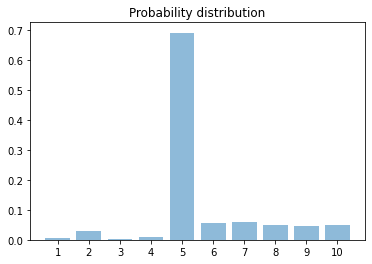

Accuracy:  0.8466838931955211


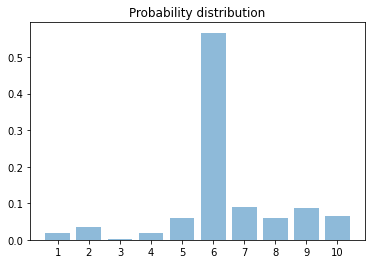

Accuracy:  0.8466838931955211


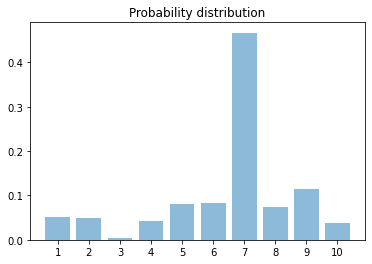

Accuracy:  0.8466838931955211


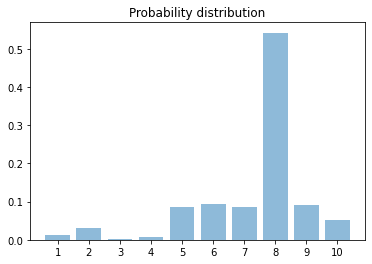

Accuracy:  0.8466838931955211


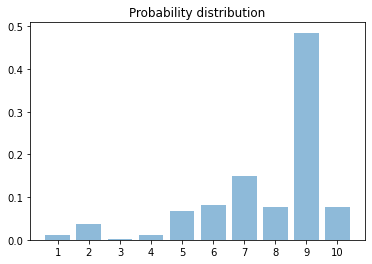

Accuracy:  0.8466838931955211


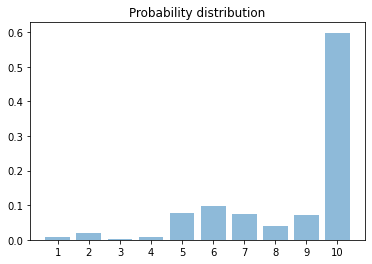

Accuracy:  0.8466838931955211


In [17]:
values1 = classifier.predict_proba(np.array(X1_Testing))
data1 = pd.DataFrame(data=values1)
data1['Y'] = y1_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data1.to_csv('87_split1_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data1.iterrows():
        if(row['Y'] == l):
            for k in range(0,10):
                probs[k] += row[k]
            count += 1
    
    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y1_Testing.size):
        if np.amax(values1[k]) == values1[k][int(y1_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

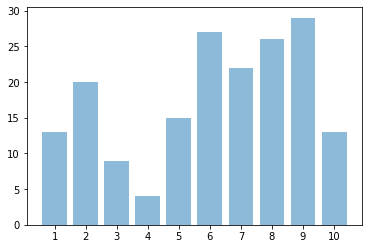

[13, 20, 9, 4, 15, 27, 22, 26, 29, 13]


In [18]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data1.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

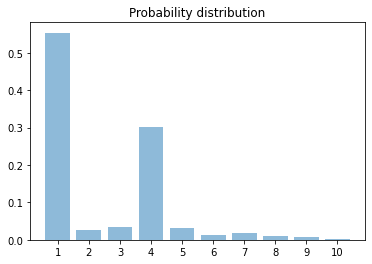

In [19]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values1[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 2

In [20]:
split2.authorship.value_counts()

BECKER       910
SLOVITER     901
STAPLETON    530
GREENBERG    520
NYGAARD      455
SCIRICA      439
ROTH         419
WEIS         412
GARTH        406
RENDELL      370
Name: authorship, dtype: int64

In [21]:
print('Number of Datapoints: ', split2.shape[0])

Number of Datapoints:  5362


In [22]:
split2names = split2.authorship.unique()

for index, name in enumerate(split2names):
    split2.authorship = split2.authorship.str.replace(name, str(index))
split2.authorship = split2.authorship.astype(int)

In [23]:
vectorizer2 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM2 = vectorizer2.fit_transform(split2.opinion)
#print(bowM2.toarray().shape)
#print(vectorizer2.get_feature_names())

In [24]:
X2 = pd.DataFrame.sparse.from_spmatrix(bowM2)
X2 = X2.sparse.to_dense()

In [25]:
for x in range(0,len(X2.columns)):
    mean = X2.iloc[:,x].mean()
    std = X2.iloc[:,x].std()
    X2.iloc[:,x] = (X2.iloc[:,x] - mean)/std

In [26]:
Y2 = split2.authorship.to_frame().reset_index().drop(columns=['index'])

X2_Training, X2_Testing, y2_Training, y2_Testing = train_test_split(X2, Y2, test_size=0.2, random_state=1234)

In [27]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_Training, y2_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X2_train), np.array(y2_train))
    values = classifier.predict_proba(np.array(X2_test))
    
    correct = 0
    counter = 0
    for k in range(0,y2_test.size):
        if np.amax(values[k]) == values[k][int(y2_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7202797202797203


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.6911421911421911


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.6911421911421911


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.703962703962704


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7016317016317016
Accuracy:  0.7016317016317016  +/-  0.010707397741590564


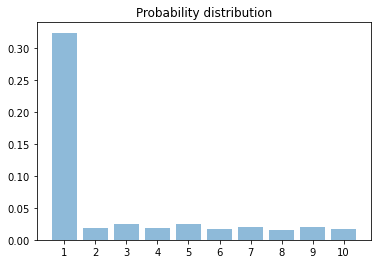

Accuracy:  0.7082945013979497


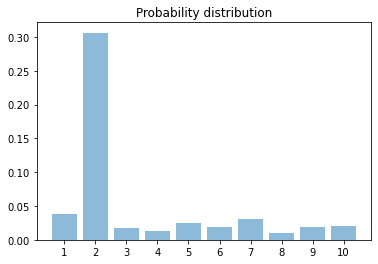

Accuracy:  0.7082945013979497


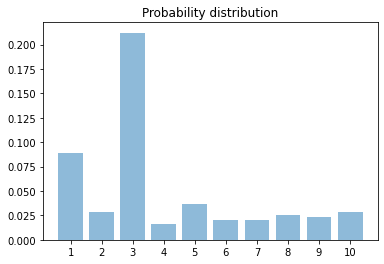

Accuracy:  0.7082945013979497


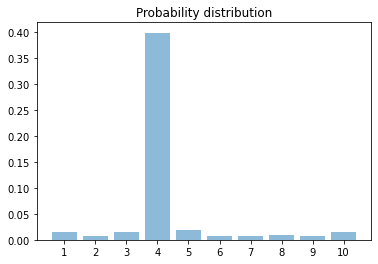

Accuracy:  0.7082945013979497


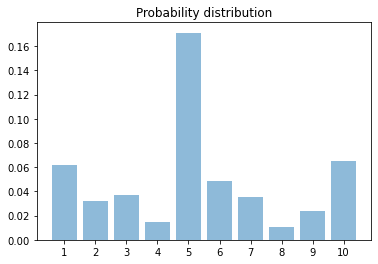

Accuracy:  0.7082945013979497


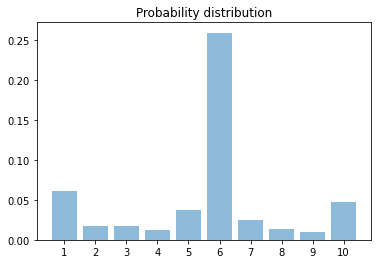

Accuracy:  0.7082945013979497


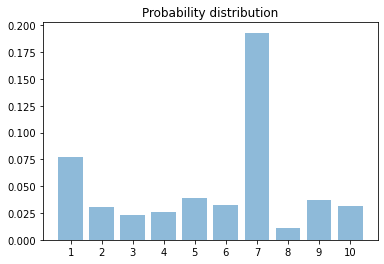

Accuracy:  0.7082945013979497


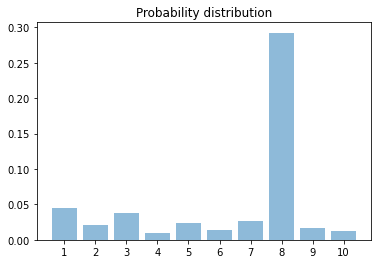

Accuracy:  0.7082945013979497


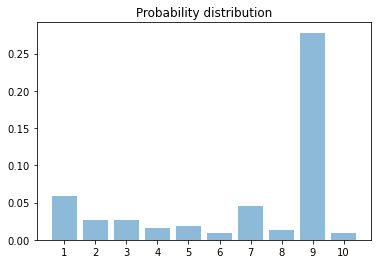

Accuracy:  0.7082945013979497


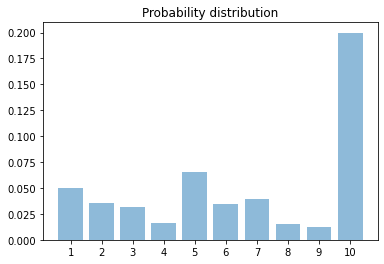

Accuracy:  0.7082945013979497


In [28]:
values2 = classifier.predict_proba(np.array(X2_Testing))
data2 = pd.DataFrame(data=values2)
data2['Y'] = y2_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data2.to_csv('87_split2_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data2.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y2_Testing.size):
        if np.amax(values2[k]) == values2[k][int(y2_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

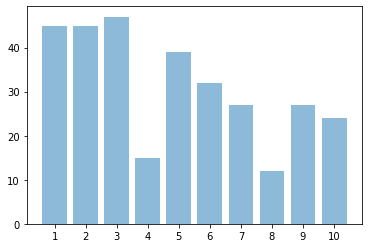

[45, 45, 47, 15, 39, 32, 27, 12, 27, 24]


In [29]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data2.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

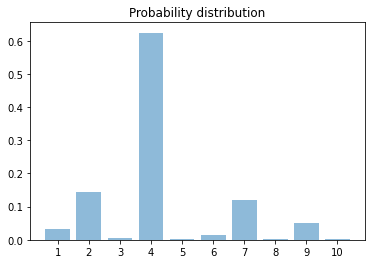

In [30]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values2[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 3

In [31]:
split3.authorship.value_counts()

RENDELL     707
AMBRO       703
FISHER      654
FUENTES     641
JORDAN      631
SMITH       619
CHAGARES    617
HARDIMAN    579
MCKEE       562
ROTH        487
Name: authorship, dtype: int64

In [32]:
print('Number of Datapoints: ', split3.shape[0])

Number of Datapoints:  6200


In [33]:
split3names = split3.authorship.unique()

for index, name in enumerate(split3names):
    split3.authorship = split3.authorship.str.replace(name, str(index))
split3.authorship = split3.authorship.astype(int)

In [34]:
vectorizer3 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM3 = vectorizer3.fit_transform(split3.opinion)
#print(bowM3.toarray().shape)
#print(vectorizer3.get_feature_names())

In [35]:
X3 = pd.DataFrame.sparse.from_spmatrix(bowM3)
X3 = X3.sparse.to_dense()

In [36]:
for x in range(0,len(X3.columns)):
    mean = X3.iloc[:,x].mean()
    std = X3.iloc[:,x].std()
    X3.iloc[:,x] = (X3.iloc[:,x] - mean)/std

In [37]:
Y3 = split3.authorship.to_frame().reset_index().drop(columns=['index'])

X3_Training, X3_Testing, y3_Training, y3_Testing = train_test_split(X3, Y3, test_size=0.2, random_state=1234)

In [38]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_Training, y3_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X3_train), np.array(y3_train))
    values = classifier.predict_proba(np.array(X3_test))
    
    correct = 0
    counter = 0
    for k in range(0,y3_test.size):
        if np.amax(values[k]) == values[k][int(y3_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7167338709677419


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.6743951612903226


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.717741935483871


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7127016129032258


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7066532258064516
Accuracy:  0.7056451612903225  +/-  0.016103810925577285


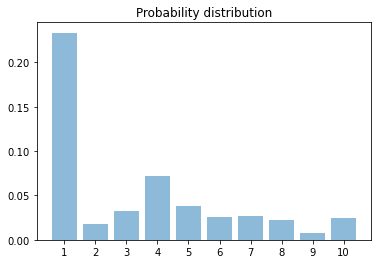

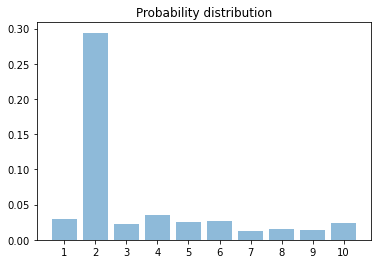

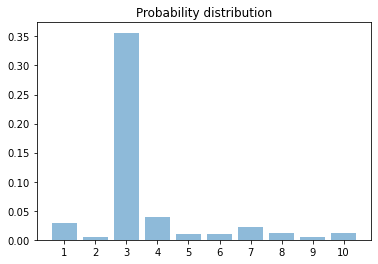

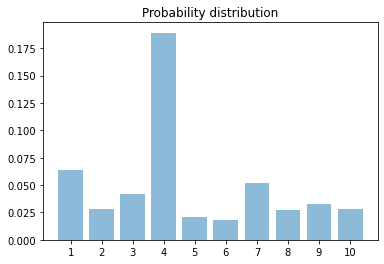

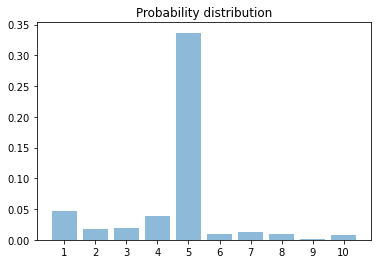

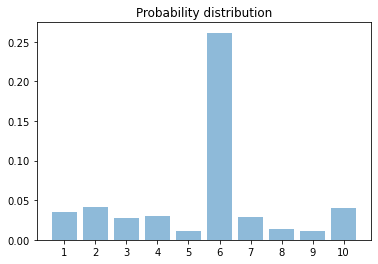

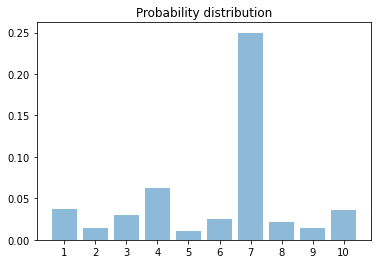

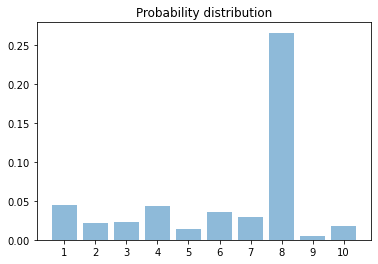

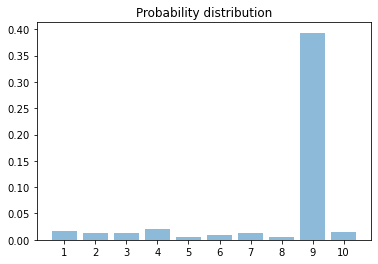

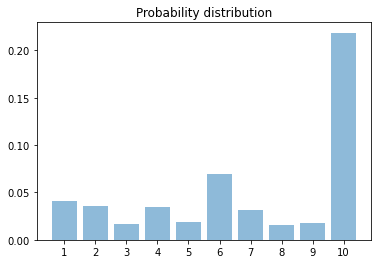

In [39]:
values3 = classifier.predict_proba(np.array(X3_Testing))
data3 = pd.DataFrame(data=values3)
data3['Y'] = y3_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data3.to_csv('87_split3_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data3.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()

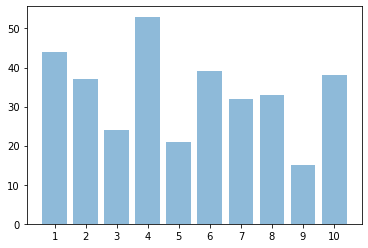

[44, 37, 24, 53, 21, 39, 32, 33, 15, 38]


In [40]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data3.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

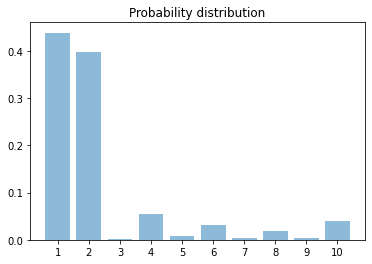

In [41]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values3[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()